In [1175]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import torch
import re
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [1176]:
df = pd.read_csv("amazon_pillows.csv")

In [1177]:
df.head()

,country,countryCode,date,filterByKeyword,filterByRating,isVerified,position,product/listPrice,product/price,productAsin,...,reviewImages/0,reviewImages/1,reviewImages/2,reviewReaction,reviewTitle,reviewUrl,reviewedIn,totalCategoryRatings,totalCategoryReviews,variant
0,United Kingdom,NaN,2024-03-06,NaN,threeStar,True,1,NaN,NaN,B00IMFWKGW,...,NaN,NaN,NaN,NaN,Disappointed,https://www.amazon.co.uk/gp/customer-reviews/R...,Reviewed in the United Kingdom on 6 March 2024,3743,405,Style Name: Super SupportSize Name: 2 Pack
1,United Kingdom,NaN,2024-03-05,NaN,threeStar,True,2,NaN,NaN,B00IMFWKGW,...,NaN,NaN,NaN,NaN,Nothing revoluntionary,https://www.amazon.co.uk/gp/customer-reviews/R...,Reviewed in the United Kingdom on 5 March 2024,3743,405,Style Name: Super SupportSize Name: 2 Pack
2,United Kingdom,NaN,2024-03-03,NaN,threeStar,True,3,NaN,NaN,B00IMFWKGW,...,NaN,NaN,NaN,NaN,Good firm support...,https://www.amazon.co.uk/gp/customer-reviews/R...,Reviewed in the United Kingdom on 3 March 2024,3743,405,Style Name: Super SupportSize Name: 2 Pack
3,United Kingdom,NaN,2024-03-03,NaN,threeStar,True,4,NaN,NaN,B00IMFWKGW,...,NaN,NaN,NaN,NaN,Slumbetdown pillows,https://www.amazon.co.uk/gp/customer-reviews/R...,Reviewed in the United Kingdom on 3 March 2024,3743,405,Style Name: Super SupportSize Name: 2 Pack
4,United Kingdom,NaN,2024-03-02,NaN,threeStar,True,5,NaN,NaN,B00IMFWKGW,...,NaN,NaN,NaN,NaN,Bouncy pillow,https://www.amazon.co.uk/gp/customer-reviews/R...,Reviewed in the United Kingdom on 2 March 2024,3743,405,Style Name: Super Support - Climate ControlSiz...


In [1178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               500 non-null    object 
 1   countryCode           0 non-null      float64
 2   date                  500 non-null    object 
 3   filterByKeyword       0 non-null      float64
 4   filterByRating        500 non-null    object 
 5   isVerified            500 non-null    bool   
 6   position              500 non-null    int64  
 7   product/listPrice     0 non-null      float64
 8   product/price         0 non-null      float64
 9   productAsin           500 non-null    object 
 10  ratingScore           500 non-null    int64  
 11  reviewCategoryUrl     500 non-null    object 
 12  reviewDescription     499 non-null    object 
 13  reviewId              500 non-null    object 
 14  reviewImages/0        20 non-null     object 
 15  reviewImages/1        6

In [1179]:
df.drop(columns = ["countryCode", "filterByKeyword", "product/listPrice", "product/price", "reviewImages/0", "reviewImages/1", "reviewImages/2", "reviewReaction", "filterByRating"], inplace=True)

In [1180]:
df["reviewDescription"] = df["reviewDescription"].convert_dtypes(convert_string=True)
df["reviewTitle"] = df["reviewTitle"].convert_dtypes(convert_string=True)

<Axes: title={'center': 'Distribution of rating scores of product'}, xlabel='ratingScore'>

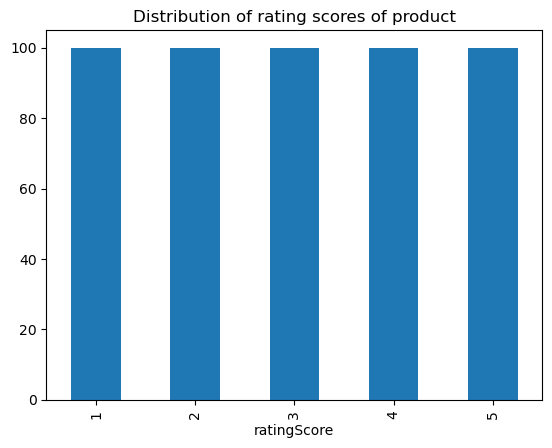

In [1181]:
df["ratingScore"].value_counts().sort_index().plot(kind = "bar", title = "Distribution of rating scores of product")

In [1182]:
#converting ratingScore to a true label
scaler = MinMaxScaler(feature_range=(-1,1))
df["ratingSentiment"] = scaler.fit_transform(df[["ratingScore"]])

In [1183]:
df_sentiment = df[["reviewDescription","reviewTitle"]]
df_sentiment = df_sentiment.dropna()
df_sentiment

,reviewDescription,reviewTitle
0,Pillows have arrived and they seem very flat c...,Disappointed
1,"Seemed to suggest they were ever plump, but so...",Nothing revoluntionary
2,Feel good...,Good firm support...
3,Expected them to be firm but they are a little...,Slumbetdown pillows
4,"Push your heads up,isn't really pillowy.Side s...",Bouncy pillow
...,...,...
495,I bought these pillows as a side sleeper but t...,Not firm
496,Its looks comfort though.,Didnt get what ordered.
497,Advertised as firm but when you lay your head ...,Not grate
498,"Really disappointed with these pillows,went fl...",Review


In [1184]:
def classify_sentiment(value):
    if value > 0:
        return 'positive'
    elif value == 0:
        return 'neutral'
    else:
        return 'negative'
df_sentiment["ratingClassified"] = df["ratingSentiment"].apply(classify_sentiment)
df_sentiment

,reviewDescription,reviewTitle,ratingClassified
0,Pillows have arrived and they seem very flat c...,Disappointed,neutral
1,"Seemed to suggest they were ever plump, but so...",Nothing revoluntionary,neutral
2,Feel good...,Good firm support...,neutral
3,Expected them to be firm but they are a little...,Slumbetdown pillows,neutral
4,"Push your heads up,isn't really pillowy.Side s...",Bouncy pillow,neutral
...,...,...,...
495,I bought these pillows as a side sleeper but t...,Not firm,negative
496,Its looks comfort though.,Didnt get what ordered.,negative
497,Advertised as firm but when you lay your head ...,Not grate,negative
498,"Really disappointed with these pillows,went fl...",Review,negative


In [1185]:
import re
from nltk.stem import WordNetLemmatizer
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for review in textdata["reviewDescription"]:
        review = review.lower()

        # Replace all URls with 'URL'
        review = re.sub(urlPattern,' URL',review)
        # Replace all non alphabets.
        review = re.sub(alphaPattern, " ", review)
        # Replace 3 or more consecutive letters by 2 letter.
        review = re.sub(sequencePattern, seqReplacePattern, review)

        reviews = ''
        for word in review.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                reviews += (word+' ')

        processedText.append(reviews)

    return processedText

In [1186]:
df_sentiment = df_sentiment.reset_index(drop = True)

In [1187]:
cleaned_df = preprocess(df_sentiment)
cleaned_df = pd.DataFrame(cleaned_df, columns = ["cleanDescription"])
cleaned_df = cleaned_df.reset_index(drop = True)


In [1188]:
df_sentiment["cleanDescription"] = cleaned_df["cleanDescription"]


In [1189]:
df_sentiment.tail()

,reviewDescription,reviewTitle,ratingClassified,cleanDescription
494,I bought these pillows as a side sleeper but t...,Not firm,negative,bought these pillow a side sleeper but they ar...
495,Its looks comfort though.,Didnt get what ordered.,negative,it look comfort though
496,Advertised as firm but when you lay your head ...,Not grate,negative,advertised a firm but when you lay your head o...
497,"Really disappointed with these pillows,went fl...",Review,negative,really disappointed with these pillow went fla...
498,I like firm pillows for great head neck suppor...,Described as firm support more soft support,negative,like firm pillow for great head neck support p...


In [1190]:
df_sentiment["ratingScore"] = df["ratingScore"]

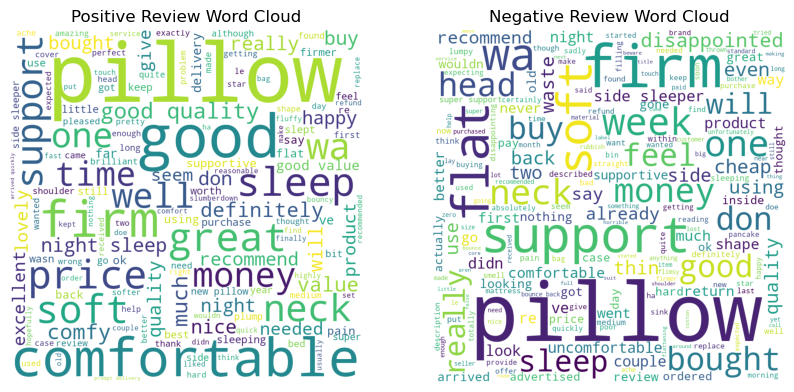

In [1191]:
#generating a wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
positive_words =[]
negative_words = []
positive_words = df_sentiment[df_sentiment['ratingScore'] >= 4]
positive_words = positive_words["cleanDescription"]
positive_text = ' '.join(positive_words)
negative_words = df_sentiment[df_sentiment['ratingScore'] <= 2]
negative_words = negative_words["cleanDescription"]
negative_text = ' '.join(negative_words)

positive_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(positive_text)
plt.figure(figsize = (10, 5))

negative_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(negative_text)

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud)
plt.title('Positive Review Word Cloud')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud)
plt.title('Negative Review Word Cloud')
plt.axis('off')
  
plt.show()
  

## Sentiment Analysis

In [1192]:
#Trying NLTK
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [1193]:
desc_pol = {}
title_pol = {}
for i, row in tqdm(df_sentiment.iterrows(), total = len(df_sentiment)):
    description = row["reviewDescription"]
    title = row["reviewTitle"]
    desc_pol[i] = sia.polarity_scores(description)
    title_pol[i] = sia.polarity_scores(title)

  0%|          | 0/499 [00:00<?, ?it/s]

In [1194]:
vaders_desc = pd.DataFrame(desc_pol).T
vaders_desc = vaders_desc.reset_index(drop=True)
vaders_desc = vaders_desc.reset_index().rename(columns={"index":"ID"})
vaders_desc

,ID,neg,neu,pos,compound
0,0,0.124,0.760,0.116,-0.0516
1,1,0.000,1.000,0.000,0.0000
2,2,0.000,1.000,0.000,0.0000
3,3,0.106,0.894,0.000,-0.0471
4,4,0.000,1.000,0.000,0.0000
...,...,...,...,...,...
494,494,0.158,0.842,0.000,-0.5504
495,495,0.000,0.545,0.455,0.3612
496,496,0.000,1.000,0.000,0.0000
497,497,0.134,0.866,0.000,-0.5256


In [1195]:
df_sentiment["ID"] = range(499)

In [1196]:
df_sentiment

,reviewDescription,reviewTitle,ratingClassified,cleanDescription,ratingScore,ID
0,Pillows have arrived and they seem very flat c...,Disappointed,neutral,pillow have arrived and they seem very flat co...,3,0
1,"Seemed to suggest they were ever plump, but so...",Nothing revoluntionary,neutral,seemed to suggest they were ever plump but soo...,3,1
2,Feel good...,Good firm support...,neutral,feel good,3,2
3,Expected them to be firm but they are a little...,Slumbetdown pillows,neutral,expected them to be firm but they are little t...,3,3
4,"Push your heads up,isn't really pillowy.Side s...",Bouncy pillow,neutral,push your head up isn really pillowy side slee...,3,4
...,...,...,...,...,...,...
494,I bought these pillows as a side sleeper but t...,Not firm,negative,bought these pillow a side sleeper but they ar...,2,494
495,Its looks comfort though.,Didnt get what ordered.,negative,it look comfort though,2,495
496,Advertised as firm but when you lay your head ...,Not grate,negative,advertised a firm but when you lay your head o...,2,496
497,"Really disappointed with these pillows,went fl...",Review,negative,really disappointed with these pillow went fla...,2,497


In [1197]:
vaders_desc = vaders_desc.merge(df_sentiment, how = 'left')
vaders_desc.head()

,ID,neg,neu,pos,compound,reviewDescription,reviewTitle,ratingClassified,cleanDescription,ratingScore
0,0,0.124,0.760,0.116,-0.0516,Pillows have arrived and they seem very flat c...,Disappointed,neutral,pillow have arrived and they seem very flat co...,3
1,1,0.000,1.000,0.000,0.0000,"Seemed to suggest they were ever plump, but so...",Nothing revoluntionary,neutral,seemed to suggest they were ever plump but soo...,3
2,2,0.000,1.000,0.000,0.0000,Feel good...,Good firm support...,neutral,feel good,3
3,3,0.106,0.894,0.000,-0.0471,Expected them to be firm but they are a little...,Slumbetdown pillows,neutral,expected them to be firm but they are little t...,3
4,4,0.000,1.000,0.000,0.0000,"Push your heads up,isn't really pillowy.Side s...",Bouncy pillow,neutral,push your head up isn really pillowy side slee...,3


In [1198]:
df["ratingScore"].dtype

dtype('int64')

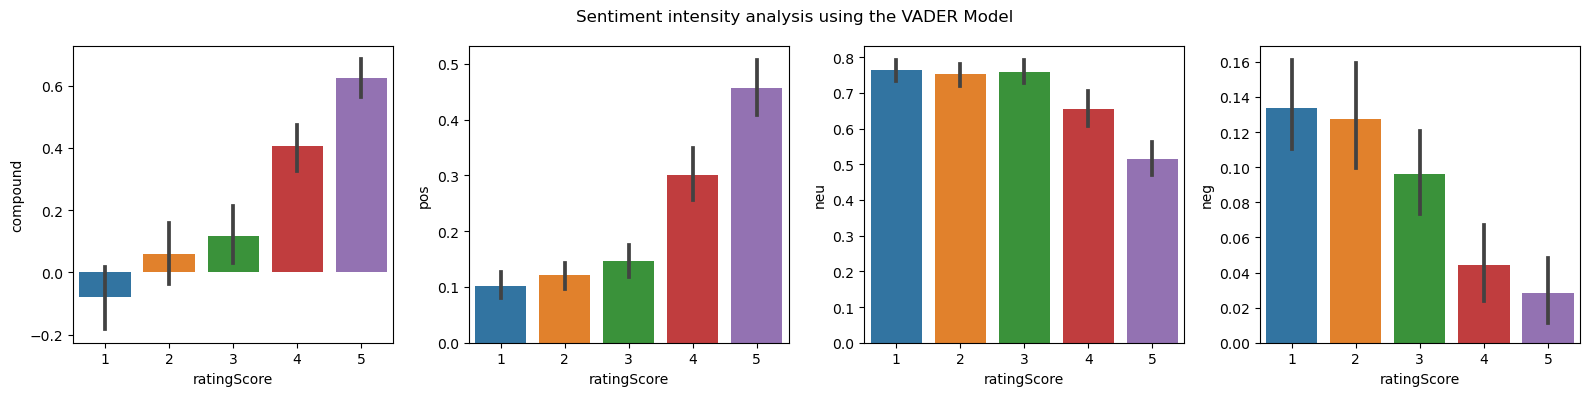

In [1199]:
fig, axs = plt.subplots(1,4, figsize = (16,4))
sns.barplot(data = vaders_desc, x ="ratingScore", y= "compound", ax = axs[0] )
sns.barplot(data = vaders_desc, x ="ratingScore", y= "pos", ax = axs[1] )
sns.barplot(data = vaders_desc, x ="ratingScore", y= "neu", ax = axs[2] )
sns.barplot(data = vaders_desc, x ="ratingScore", y= "neg", ax = axs[3] )
plt.suptitle("Sentiment intensity analysis using the VADER Model")
plt.tight_layout()
plt.show()

In [1200]:
## Roberta model
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

In [1201]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [1202]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors="tf")
    output = model(**encoded_text)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    scores_dict = {
        "roberta_neg" : scores[0],
        "roberta_neu" : scores[1],
        "roberta_pos" : scores[2]
    }
    return scores_dict

In [1203]:
desc_pol = {}
title_pol = {}
roberta_desc = {}
for i, row in tqdm(df_sentiment.iterrows(), total = len(df_sentiment)):
    description = row["cleanDescription"]
    title = row["reviewTitle"]
    desc_pol[i] = sia.polarity_scores(description)
    title_pol[i] = sia.polarity_scores(title)

    roberta_desc[i] = polarity_scores_roberta(description)

  0%|          | 0/499 [00:00<?, ?it/s]

In [1204]:
roberta_desc = pd.DataFrame(roberta_desc).T

In [1205]:
roberta_desc

,roberta_neg,roberta_neu,roberta_pos
0,0.752565,0.228394,0.019041
1,0.552543,0.414211,0.033246
2,0.003992,0.065567,0.930441
3,0.420520,0.515974,0.063506
4,0.239308,0.670060,0.090632
...,...,...,...
494,0.700593,0.260149,0.039258
495,0.029830,0.422211,0.547959
496,0.760437,0.220779,0.018784
497,0.913782,0.079085,0.007133


In [1206]:
roberta_desc = roberta_desc.reset_index(drop=True)
roberta_desc

,roberta_neg,roberta_neu,roberta_pos
0,0.752565,0.228394,0.019041
1,0.552543,0.414211,0.033246
2,0.003992,0.065567,0.930441
3,0.420520,0.515974,0.063506
4,0.239308,0.670060,0.090632
...,...,...,...
494,0.700593,0.260149,0.039258
495,0.029830,0.422211,0.547959
496,0.760437,0.220779,0.018784
497,0.913782,0.079085,0.007133


In [1207]:
#roberta_desc.drop(columns=["ID"], inplace=True)

In [1208]:
roberta_desc = roberta_desc.reset_index().rename(columns={"index":"ID"})
roberta_desc

,ID,roberta_neg,roberta_neu,roberta_pos
0,0,0.752565,0.228394,0.019041
1,1,0.552543,0.414211,0.033246
2,2,0.003992,0.065567,0.930441
3,3,0.420520,0.515974,0.063506
4,4,0.239308,0.670060,0.090632
...,...,...,...,...
494,494,0.700593,0.260149,0.039258
495,495,0.029830,0.422211,0.547959
496,496,0.760437,0.220779,0.018784
497,497,0.913782,0.079085,0.007133


In [1209]:
roberta_desc = roberta_desc.merge(df_sentiment, how = 'left')

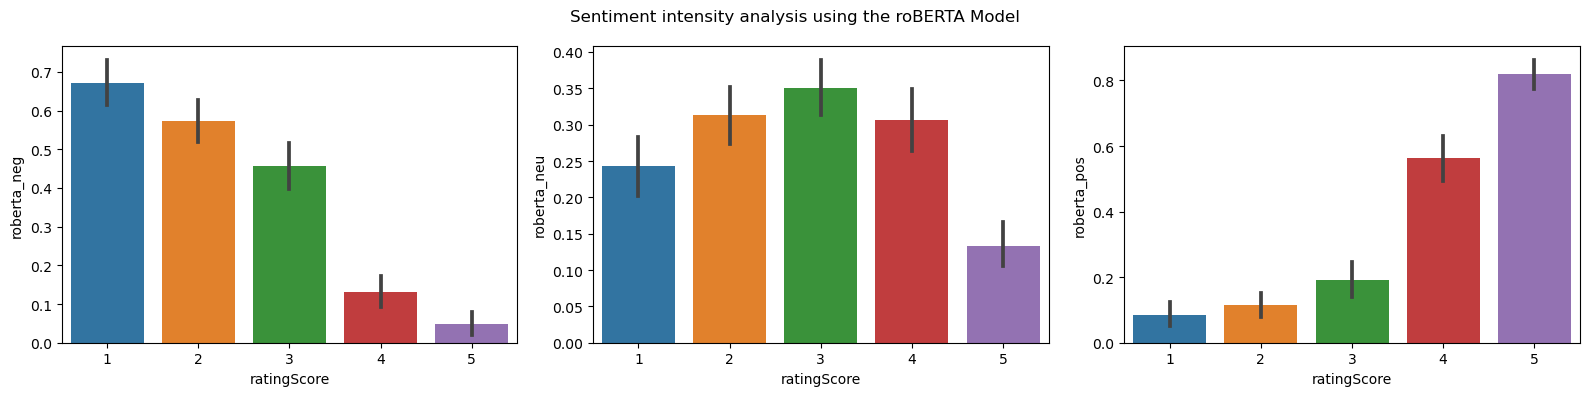

In [1210]:
fig, axs = plt.subplots(1,3, figsize = (16,4))
sns.barplot(data = roberta_desc, x ="ratingScore", y= "roberta_neg", ax = axs[0] )
sns.barplot(data = roberta_desc, x ="ratingScore", y= "roberta_neu", ax = axs[1] )
sns.barplot(data = roberta_desc, x ="ratingScore", y= "roberta_pos", ax = axs[2] )
plt.suptitle("Sentiment intensity analysis using the roBERTA Model")
plt.tight_layout()
plt.show()

In [1211]:
## Reviewing some of the examples
## VADER pos 1star
vaders_desc.query("ratingScore == 1").sort_values("pos", ascending=False)["cleanDescription"].values[0]

'arrived on time very comfortable recommended '

In [1212]:
##Roberta pos 1star
roberta_desc.query("ratingScore == 1").sort_values("roberta_pos", ascending=False)["cleanDescription"].values[0]

'bought this because it stated firm pillow it is so soft once you put your head on it you might a well be putting your head straight on the mattress not wasted my husband love it '

In [1213]:
##VADER neg 5star
vaders_desc.query("ratingScore == 5").sort_values("neg", ascending=False)["cleanDescription"].values[0]

'disliked nothing '

In [1214]:
##Roberta neg 5star
roberta_desc.query("ratingScore == 5").sort_values("roberta_neg", ascending=False)["cleanDescription"].values[0]

'these pillow are useless not firm a stated and they are flat a pancake don recommend at all '

## Machine Learning Models Predictions with TF-IDF

In [1215]:
#Trying logistic regression 
y = df_sentiment["ratingClassified"]
X = df_sentiment["cleanDescription"]

X_train, X_test, y_train, y_test  = train_test_split(X,y, train_size=0.75, random_state=32)

In [1216]:
model = Pipeline((("vect", TfidfVectorizer()),("clc", LogisticRegression(solver = "liblinear", max_iter=500))))
model.fit(X_train,y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clc', LogisticRegression(max_iter=500, solver='liblinear'))])

In [1217]:
y_pred = model.predict(X_test)

In [1218]:
result_log = {"Actual": y_test, "Pred": y_pred}
output = pd.DataFrame(result_log)
output

,Actual,Pred
27,negative,negative
291,negative,negative
427,positive,positive
269,negative,negative
218,negative,negative
...,...,...
333,positive,positive
442,negative,negative
312,neutral,positive
124,positive,positive


In [1219]:
print('Accuracy:', acc(y_test, y_pred))

Accuracy: 0.696


Text(0.5, 1.0, 'Confusion Matrix for LR')

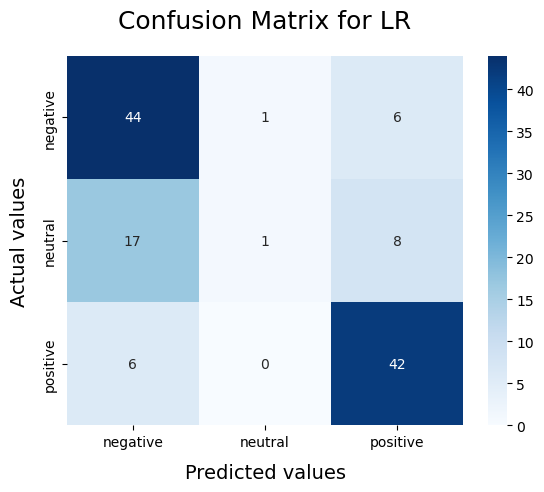

In [1220]:
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ["negative", "neutral", "positive"]
sns.heatmap(cf_matrix, annot = True, xticklabels= categories, yticklabels= categories, cmap = "Blues")
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for LR", fontdict = {'size':18}, pad = 20)

In [1221]:
## trying the SVM model
model = Pipeline((("vect", TfidfVectorizer()),("svm", SVC(kernel = "linear"))))
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('Accuracy:', acc(y_test, y_pred))

Accuracy: 0.704


Text(0.5, 1.0, 'Confusion Matrix for SVM')

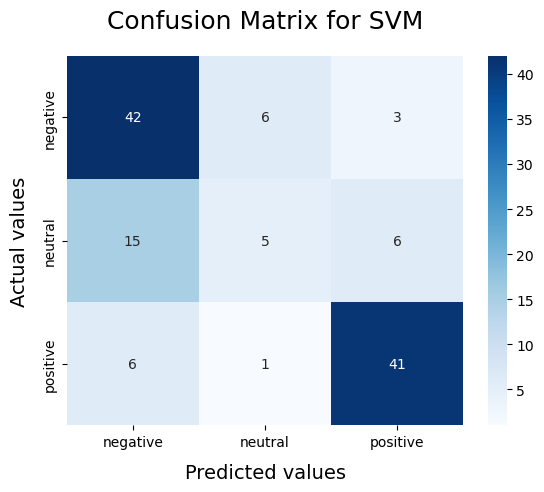

In [1222]:
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ["negative", "neutral", "positive"]
sns.heatmap(cf_matrix, annot = True, xticklabels= categories, yticklabels= categories, cmap = "Blues")
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for SVM", fontdict = {'size':18}, pad = 20)

In [1223]:
#trying the randomforest model
model = Pipeline((("vect", TfidfVectorizer()),("rf", RandomForestClassifier(n_estimators=500, criterion="entropy"))))
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('Accuracy:', acc(y_test, y_pred))

Accuracy: 0.672


Text(0.5, 1.0, 'Confusion Matrix for RF')

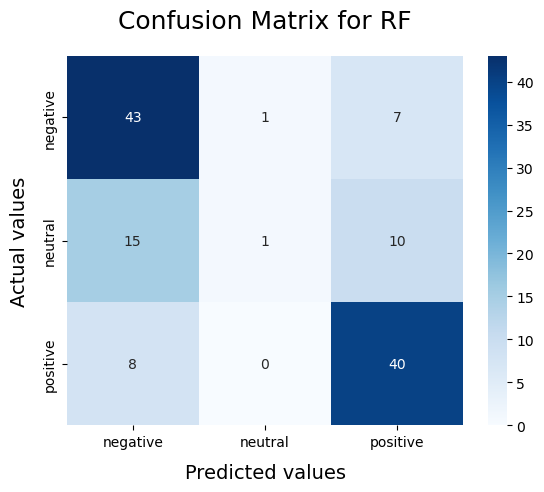

In [1224]:
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ["negative", "neutral", "positive"]
sns.heatmap(cf_matrix, annot = True, xticklabels= categories, yticklabels= categories, cmap = "Blues")
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for RF", fontdict = {'size':18}, pad = 20)

## Classifying using VADER and roBERTa

In [1225]:
vaders_desc.tail()

,ID,neg,neu,pos,compound,reviewDescription,reviewTitle,ratingClassified,cleanDescription,ratingScore
494,494,0.158,0.842,0.000,-0.5504,I bought these pillows as a side sleeper but t...,Not firm,negative,bought these pillow a side sleeper but they ar...,2
495,495,0.000,0.545,0.455,0.3612,Its looks comfort though.,Didnt get what ordered.,negative,it look comfort though,2
496,496,0.000,1.000,0.000,0.0000,Advertised as firm but when you lay your head ...,Not grate,negative,advertised a firm but when you lay your head o...,2
497,497,0.134,0.866,0.000,-0.5256,"Really disappointed with these pillows,went fl...",Review,negative,really disappointed with these pillow went fla...,2
498,498,0.128,0.559,0.313,0.8736,I like firm pillows for great head neck suppor...,Described as firm support more soft support,negative,like firm pillow for great head neck support p...,2


In [1226]:
vader_classify = []
for row in vaders_desc["compound"]:
    if row > 0.05:
        vader_classify.append("positive")
    elif row < -0.05:
        vader_classify.append("negative")
    else:
        vader_classify.append("neutral")

In [1227]:
vader_classify = pd.DataFrame(vader_classify, columns= ["vader classification"])
vader_classify

,vader classification
0,negative
1,neutral
2,neutral
3,neutral
4,neutral
...,...
494,negative
495,positive
496,neutral
497,negative


In [1228]:
vader_classify.value_counts()

vader classification
positive                300
negative                132
neutral                  67
Name: count, dtype: int64

In [1229]:
print('Accuracy:', acc(vaders_desc["ratingClassified"], vader_classify))

Accuracy: 0.5651302605210421


Text(0.5, 1.0, 'Confusion Matrix for VADER')

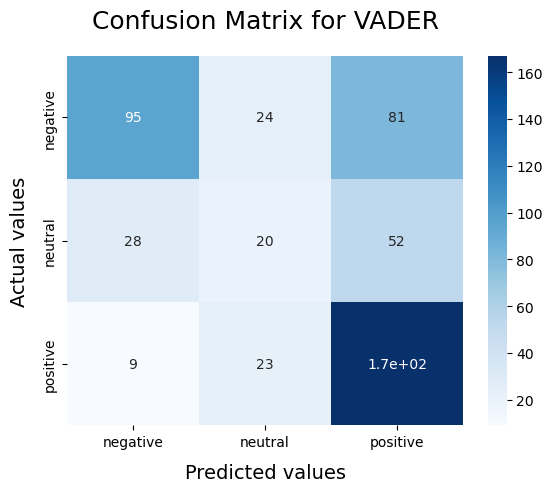

In [1230]:
cf_matrix = confusion_matrix(vaders_desc["ratingClassified"], vader_classify)
categories = ["negative", "neutral", "positive"]
sns.heatmap(cf_matrix, annot = True, xticklabels= categories, yticklabels= categories, cmap = "Blues")
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for VADER", fontdict = {'size':18}, pad = 20)

In [1231]:
# Iterate over predictions
roberta_classify = []
for row in range(len(roberta_desc)):
    # Extract predicted probabilities for each class
    prob_positive = roberta_desc["roberta_pos"][row]
    prob_neutral = roberta_desc["roberta_neu"][row]
    prob_negative = roberta_desc["roberta_neg"][row]
    
    # Compare probabilities and classify
    if prob_positive >= prob_neutral and prob_positive >= prob_negative:
        roberta_classify.append("positive")
    elif prob_neutral >= prob_positive and prob_neutral >= prob_negative:
        roberta_classify.append("neutral")
    else:
        roberta_classify.append("negative")

In [1232]:
roberta_classify = pd.DataFrame(roberta_classify, columns= ["roBERTa classification"])
roberta_classify

,roBERTa classification
0,negative
1,negative
2,positive
3,neutral
4,neutral
...,...
494,negative
495,positive
496,negative
497,negative


In [1233]:
roberta_classify.value_counts()

roBERTa classification
negative                  208
positive                  182
neutral                   109
Name: count, dtype: int64

In [1234]:
print('Accuracy:', acc(roberta_desc["ratingClassified"], roberta_classify))

Accuracy: 0.657314629258517


Text(0.5, 1.0, 'Confusion Matrix for roBERTa')

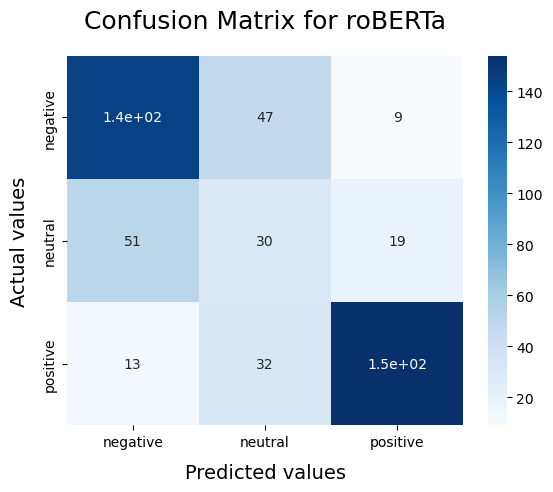

In [1235]:
cf_matrix = confusion_matrix(roberta_desc["ratingClassified"], roberta_classify)
categories = ["negative", "neutral", "positive"]
sns.heatmap(cf_matrix, annot = True, xticklabels= categories, yticklabels= categories, cmap = "Blues")
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for roBERTa", fontdict = {'size':18}, pad = 20)

## Machine Learning Models RNN and CNN

In [1256]:
X = df_sentiment["cleanDescription"]
y = df_sentiment["ratingClassified"]

In [1257]:
from keras.utils import to_categorical
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

y = to_categorical(y)
X = pd.DataFrame(X)
X = X.cleanDescription


In [1258]:
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [1259]:
X

0      pillow have arrived and they seem very flat co...
1      seemed to suggest they were ever plump but soo...
2                                             feel good 
3      expected them to be firm but they are little t...
4      push your head up isn really pillowy side slee...
                             ...                        
494    bought these pillow a side sleeper but they ar...
495                              it look comfort though 
496    advertised a firm but when you lay your head o...
497    really disappointed with these pillow went fla...
498    like firm pillow for great head neck support p...
Name: cleanDescription, Length: 499, dtype: object

In [1260]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y)

max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()
X_train
max_words, max_len

(1161, 930)

In [ ]:
# Deep Learing Preprocessing - Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence


# Deep Learning Model - Keras
from keras.models import Model
from keras.models import Sequential
from sklearn.utils import class_weight as cw

In [ ]:
# Deep Learning Model - Keras - CNN
from keras.layers import Conv1D, GlobalMaxPooling1D 

# Deep Learning Model - Keras - RNN
from keras.layers import Embedding, LSTM

# Deep Learning Model - Keras - General
from keras.layers import Dense, BatchNormalization, Dropout

# Deep Learning Parameters - Keras
from keras.optimizers import Adam


In [ ]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq = sequence.pad_sequences(X_train_seq, maxlen=max_len)

In [ ]:
def get_rnn_model(num_class=2):
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(LSTM(24))
    
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(48, activation='relu'))
    
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    if num_class>2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    return model


def get_cnn_model(num_class=2):   
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    
    model.add(Conv1D(24, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    
    
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(48, activation='relu'))
    
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    if num_class>2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    return model

In [ ]:
num_class = 3
model1 = get_rnn_model(num_class=num_class)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 930, 100)          115200    
                                                                 
 lstm_6 (LSTM)               (None, 24)                12000     
                                                                 
 dropout_352 (Dropout)       (None, 24)                0         
                                                                 
 batch_normalization_24 (Ba  (None, 24)                96        
 tchNormalization)                                               
                                                                 
 dropout_353 (Dropout)       (None, 24)                0         
                                                                 
 dense_24 (Dense)            (None, 48)                1200      
                                                     

In [ ]:
loss = 'categorical_crossentropy'
metrics = ['accuracy']

In [ ]:
learning_rate = 0.001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

verbose = 1
epochs = 50
batch_size = 25
validation_split = 0.2

print("Training Model ...\n")

history1 = model1.fit(
    X_train_seq,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=validation_split,
)

Training Model ...

Epoch 1/50
13/13 [==============================] - 5s 209ms/step - loss: 1.6739 - accuracy: 0.3648 - val_loss: 1.0771 - val_accuracy: 0.5125
Epoch 2/50
13/13 [==============================] - 2s 170ms/step - loss: 1.4287 - accuracy: 0.4371 - val_loss: 1.0613 - val_accuracy: 0.4875
Epoch 3/50
13/13 [==============================] - 2s 186ms/step - loss: 1.1547 - accuracy: 0.5126 - val_loss: 1.0504 - val_accuracy: 0.5250
Epoch 4/50
13/13 [==============================] - 3s 199ms/step - loss: 1.0919 - accuracy: 0.5063 - val_loss: 1.0447 - val_accuracy: 0.5250
Epoch 5/50
13/13 [==============================] - 2s 178ms/step - loss: 1.0159 - accuracy: 0.5692 - val_loss: 1.0412 - val_accuracy: 0.5375
Epoch 6/50
13/13 [==============================] - 2s 163ms/step - loss: 0.8467 - accuracy: 0.6132 - val_loss: 1.0410 - val_accuracy: 0.5375
Epoch 7/50
13/13 [==============================] - 2s 170ms/step - loss: 0.8253 - accuracy: 0.6730 - val_loss: 1.0414 - val_acc

In [ ]:
tokenizer.fit_on_texts(X_test)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = sequence.pad_sequences(X_test_seq, maxlen=max_len)
y_pred_ann = model1.predict(X_test_seq)
y_pred_ann_classify = []
for row in range(len(y_pred_ann)):
    # Extract predicted probabilities for each class
    prob_negative = y_pred_ann[row][0]
    prob_neutral = y_pred_ann[row][1]
    prob_positive = y_pred_ann[row][2]
    
    # Compare probabilities and classify
    if prob_positive >= prob_neutral and prob_positive >= prob_negative:
        y_pred_ann_classify.append("positive")
    elif prob_neutral >= prob_positive and prob_neutral >= prob_negative:
        y_pred_ann_classify.append("neutral")
    else:
        y_pred_ann_classify.append("negative")

4/4 [==============================] - 1s 29ms/step


In [ ]:
Y_test_classify = []
# Iterate over the rows
for row_index, row in enumerate(Y_test):
    # Iterate over columns within each row
    for col_index, value in enumerate(row):
        if col_index == 0 and value ==1:
            Y_test_classify.append("negative")
        elif col_index == 1 and value == 1:
            Y_test_classify.append("neutral")
        elif col_index == 2 and value == 1:
            Y_test_classify.append("positive")

In [ ]:
print('Accuracy:', acc(Y_test_classify, y_pred_ann_classify))

Accuracy: 0.38


Text(0.5, 1.0, 'Confusion Matrix for RNN')

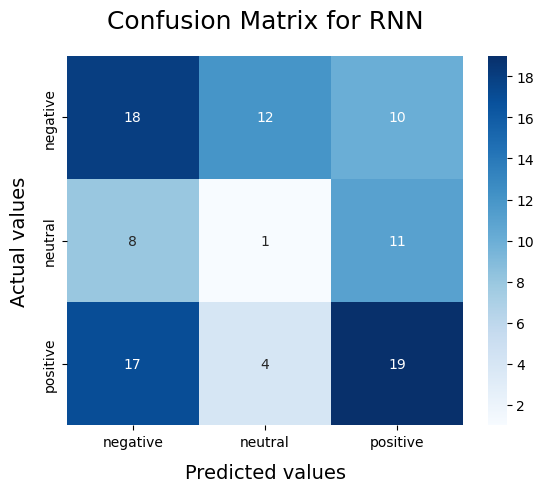

In [ ]:
cf_matrix = confusion_matrix(Y_test_classify, y_pred_ann_classify)
categories = ["negative", "neutral", "positive"]
sns.heatmap(cf_matrix, annot = True, xticklabels= categories, yticklabels= categories, cmap = "Blues")
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for RNN", fontdict = {'size':18}, pad = 20)

In [ ]:
num_class = 3
model2 = get_cnn_model(num_class=num_class)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 533, 100)          160100    
                                                                 
 conv1d_5 (Conv1D)           (None, 531, 24)           7224      
                                                                 
 global_max_pooling1d_5 (Gl  (None, 24)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_272 (Dropout)       (None, 24)                0         
                                                                 
 batch_normalization_22 (Ba  (None, 24)                96        
 tchNormalization)                                               
                                                                 
 dropout_273 (Dropout)       (None, 24)              

In [ ]:
learning_rate = 0.001
optimizer = Adam(learning_rate)

model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

verbose = 1
epochs = 50
batch_size = 25
validation_split = 0.2

print("Training Model ...\n")

history2 = model2.fit(
    X_train_seq,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=validation_split
    )

Training Model ...

Epoch 1/50
13/13 [==============================] - 2s 22ms/step - loss: 1.6072 - accuracy: 0.3793 - val_loss: 1.0944 - val_accuracy: 0.3625
Epoch 2/50
13/13 [==============================] - 0s 9ms/step - loss: 1.2264 - accuracy: 0.4545 - val_loss: 1.1000 - val_accuracy: 0.3375
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 1.1961 - accuracy: 0.4984 - val_loss: 1.1169 - val_accuracy: 0.3375
Epoch 4/50
13/13 [==============================] - 0s 12ms/step - loss: 0.9568 - accuracy: 0.5799 - val_loss: 1.1387 - val_accuracy: 0.3375
Epoch 5/50
13/13 [==============================] - 0s 9ms/step - loss: 0.9259 - accuracy: 0.5831 - val_loss: 1.1625 - val_accuracy: 0.3375
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 0.9234 - accuracy: 0.6144 - val_loss: 1.1907 - val_accuracy: 0.3375
Epoch 7/50
13/13 [==============================] - 0s 9ms/step - loss: 0.8059 - accuracy: 0.6614 - val_loss: 1.2175 - val_accuracy: 0.337

In [ ]:
y_pred_ann = model2.predict(X_test_seq)
y_pred_ann_classify = []
for row in range(len(y_pred_ann)):
    # Extract predicted probabilities for each class
    prob_negative = y_pred_ann[row][0]
    prob_neutral = y_pred_ann[row][1]
    prob_positive = y_pred_ann[row][2]
    
    # Compare probabilities and classify
    if prob_positive >= prob_neutral and prob_positive >= prob_negative:
        y_pred_ann_classify.append("positive")
    elif prob_neutral >= prob_positive and prob_neutral >= prob_negative:
        y_pred_ann_classify.append("neutral")
    else:
        y_pred_ann_classify.append("negative")

4/4 [==============================] - 0s 3ms/step


In [ ]:
y_pred_ann

array([[0.92539954, 0.01924963, 0.05535082],
       [0.42646042, 0.1804623 , 0.3930772 ],
       [0.32938161, 0.06697347, 0.6036449 ],
       [0.01901427, 0.03609845, 0.9448873 ],
       [0.03731445, 0.04911057, 0.913575  ],
       [0.9705931 , 0.00749008, 0.0219168 ],
       [0.9111987 , 0.01115817, 0.07764308],
       [0.37133586, 0.41060582, 0.21805835],
       [0.0180845 , 0.01287674, 0.9690387 ],
       [0.74500215, 0.06229741, 0.19270043],
       [0.05302446, 0.02985382, 0.9171217 ],
       [0.6736582 , 0.15123871, 0.17510311],
       [0.14546978, 0.0819798 , 0.7725504 ],
       [0.29969805, 0.04795542, 0.6523465 ],
       [0.8630891 , 0.02558153, 0.11132941],
       [0.60763377, 0.37368298, 0.01868323],
       [0.9637104 , 0.00320647, 0.03308304],
       [0.93491185, 0.04928932, 0.01579883],
       [0.15182017, 0.12809543, 0.72008437],
       [0.93762934, 0.03028439, 0.03208625],
       [0.11223651, 0.06271678, 0.8250467 ],
       [0.30920926, 0.0165725 , 0.6742182 ],
       [0.

In [ ]:
Y_test_classify = []
# Iterate over the rows
for row_index, row in enumerate(Y_test):
    # Iterate over columns within each row
    for col_index, value in enumerate(row):
        if col_index == 0 and value ==1:
            Y_test_classify.append("negative")
        elif col_index == 1 and value == 1:
            Y_test_classify.append("neutral")
        elif col_index == 2 and value == 1:
            Y_test_classify.append("positive")

In [ ]:
print(len(Y_test_classify))

100


In [ ]:
print('Accuracy:', acc(Y_test_classify, y_pred_ann_classify))

Accuracy: 0.5


Text(0.5, 1.0, 'Confusion Matrix for CNN')

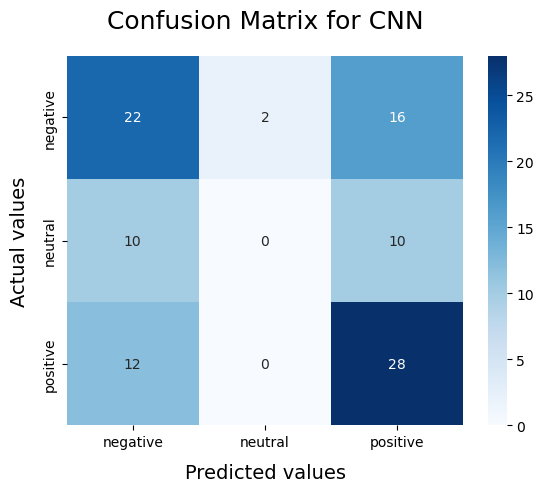

In [ ]:
cf_matrix = confusion_matrix(Y_test_classify, y_pred_ann_classify)
categories = ["negative", "neutral", "positive"]
sns.heatmap(cf_matrix, annot = True, xticklabels= categories, yticklabels= categories, cmap = "Blues")
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for CNN", fontdict = {'size':18}, pad = 20)